## Import necesarry packages

In [55]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.preprocessing import OneHotEncoder
from sklearn import set_config
from sksurv.linear_model import CoxPHSurvivalAnalysis
from statsmodels.stats.outliers_influence import variance_inflation_factor

## Exploratory data analysis (EDA)

In [56]:
# parse data
df = pd.read_csv("breast_cancer.csv")
# show head
pd.set_option('display.max_columns', None)
df.head()


,patient_id,age_at_diagnosis,type_of_breast_surgery,cancer_type,cancer_type_detailed,cellularity,chemotherapy,cohort,er_status_measured_by_ihc,er_status,neoplasm_histologic_grade,her2_status,hormone_therapy,inferred_menopausal_state,primary_tumor_laterality,lymph_nodes_examined_positive,mutation_count,nottingham_prognostic_index,overall_survival_months,overall_survival,pr_status,radio_therapy,tumor_size,tumor_stage,death_from_cancer
0,0,75.65,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,0,1,Positve,Positive,3.0,Negative,1,Post,Right,10,NaN,6.044,140.500000,1,Negative,1,22.0,2.0,Living
1,2,43.19,BREAST CONSERVING,Breast Cancer,Breast Invasive Ductal Carcinoma,High,0,1,Positve,Positive,3.0,Negative,1,Pre,Right,0,2.0,4.020,84.633333,1,Positive,1,10.0,1.0,Living
2,5,48.87,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,1,1,Positve,Positive,2.0,Negative,1,Pre,Right,1,2.0,4.030,163.700000,0,Positive,0,15.0,2.0,Died of Disease
3,6,47.68,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Moderate,1,1,Positve,Positive,2.0,Negative,1,Pre,Right,3,1.0,4.050,164.933333,1,Positive,1,25.0,2.0,Living
4,8,76.97,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,1,1,Positve,Positive,3.0,Negative,1,Post,Right,8,2.0,6.080,41.366667,0,Positive,1,40.0,2.0,Died of Disease


In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1904 entries, 0 to 1903
Data columns (total 25 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   patient_id                     1904 non-null   int64  
 1   age_at_diagnosis               1904 non-null   float64
 2   type_of_breast_surgery         1882 non-null   object 
 3   cancer_type                    1904 non-null   object 
 4   cancer_type_detailed           1889 non-null   object 
 5   cellularity                    1850 non-null   object 
 6   chemotherapy                   1904 non-null   int64  
 7   cohort                         1904 non-null   int64  
 8   er_status_measured_by_ihc      1874 non-null   object 
 9   er_status                      1904 non-null   object 
 10  neoplasm_histologic_grade      1832 non-null   float64
 11  her2_status                    1904 non-null   object 
 12  hormone_therapy                1904 non-null   i

In [194]:
df.describe()

,age_at_diagnosis,chemotherapy,cohort,neoplasm_histologic_grade,hormone_therapy,lymph_nodes_examined_positive,mutation_count,nottingham_prognostic_index,overall_survival_months,overall_survival,radio_therapy,tumor_size,tumor_stage
count,1904.000000,1904.000000,1904.000000,1832.000000,1904.000000,1904.000000,1859.000000,1904.000000,1904.000000,1904.000000,1904.000000,1884.000000,1403.000000
mean,61.087054,0.207983,2.643908,2.415939,0.616597,2.002101,5.697687,4.033019,125.121324,0.420693,0.597164,26.238726,1.750535
std,12.978711,0.405971,1.228615,0.650612,0.486343,4.079993,4.058778,1.144492,76.334148,0.493800,0.490597,15.160976,0.628999
min,21.930000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,51.375000,0.000000,1.000000,2.000000,0.000000,0.000000,3.000000,3.046000,60.825000,0.000000,0.000000,17.000000,1.000000
50%,61.770000,0.000000,3.000000,3.000000,1.000000,0.000000,5.000000,4.042000,115.616667,0.000000,1.000000,23.000000,2.000000
75%,70.592500,0.000000,3.000000,3.000000,1.000000,2.000000,7.000000,5.040250,184.716667,1.000000,1.000000,30.000000,2.000000
max,96.290000,1.000000,5.000000,3.000000,1.000000,45.000000,80.000000,6.360000,355.200000,1.000000,1.000000,182.000000,4.000000


First findings:
* The data set contains 24 columns of which 1 is an id column, 17 are categorical and 6 are numerical.
* There are 11 categorical columns with data type object
* There are 6 categorical columns with data type int64 (4 of which are binary)
* 9 Columns contain empty values

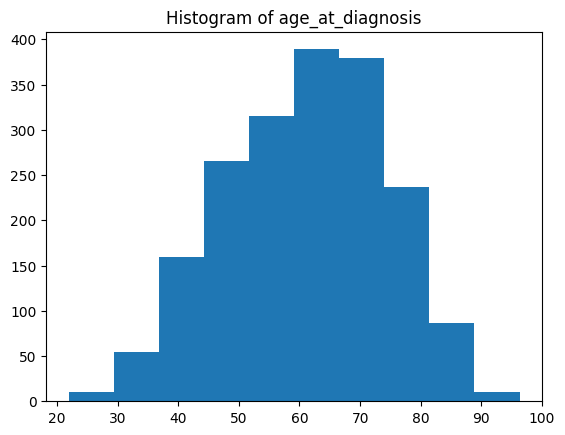

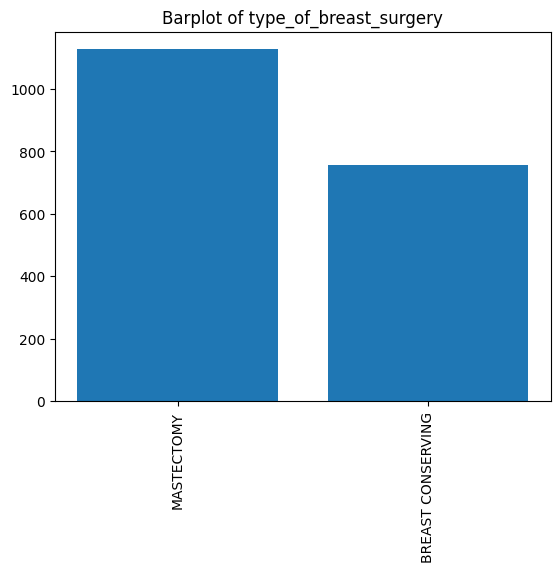

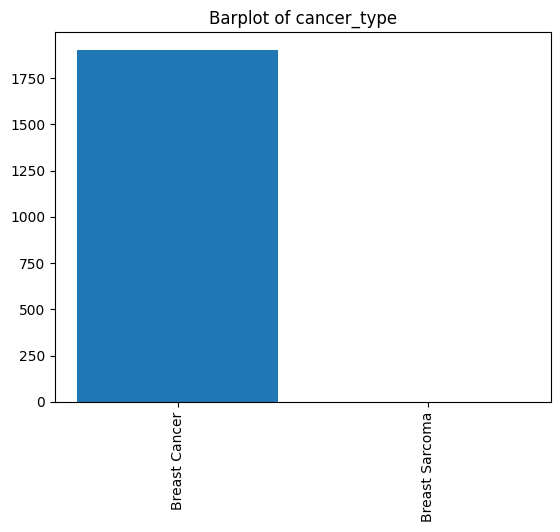

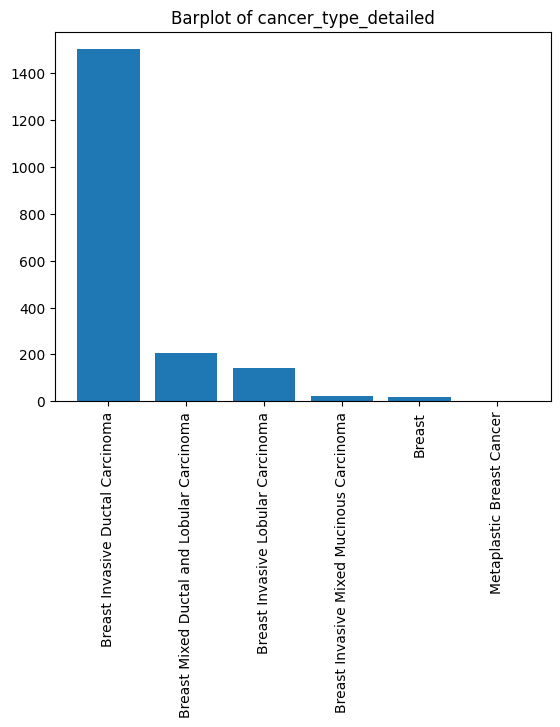

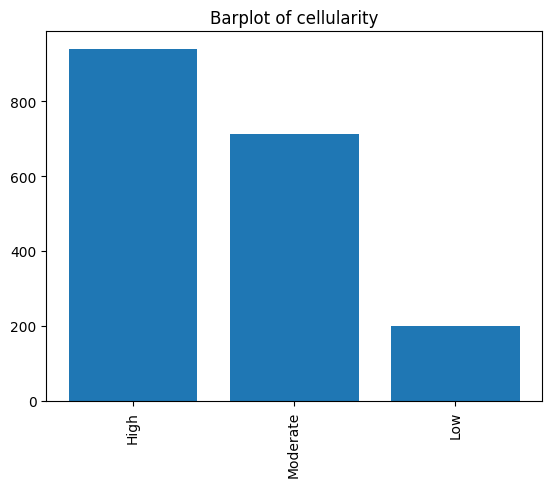

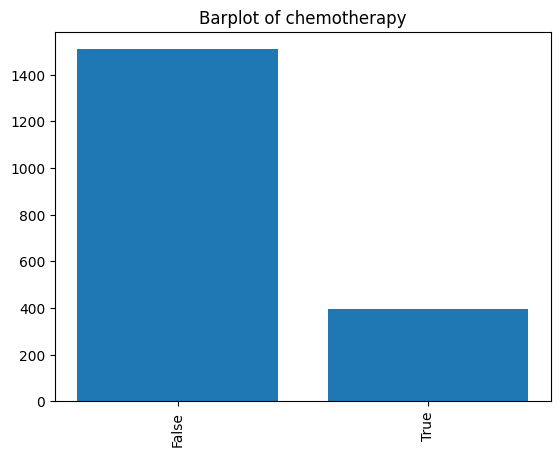

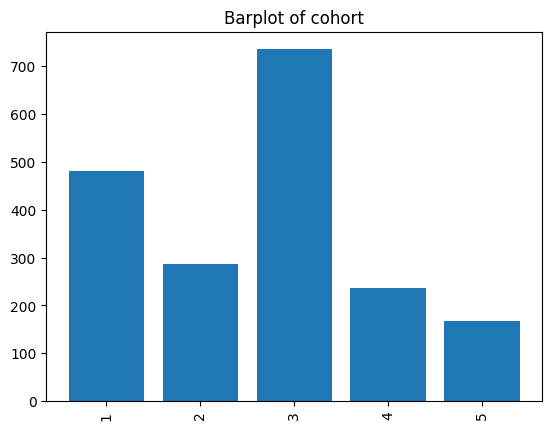

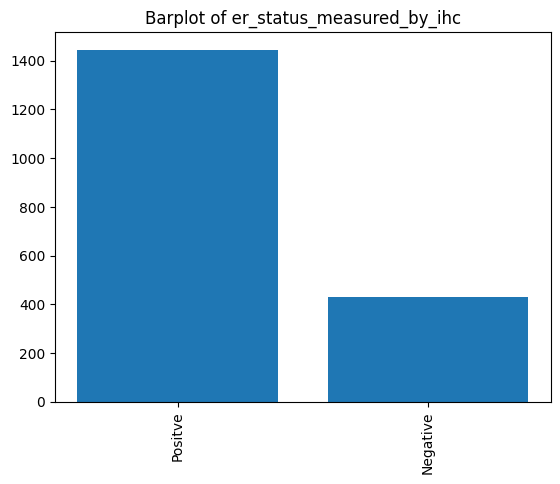

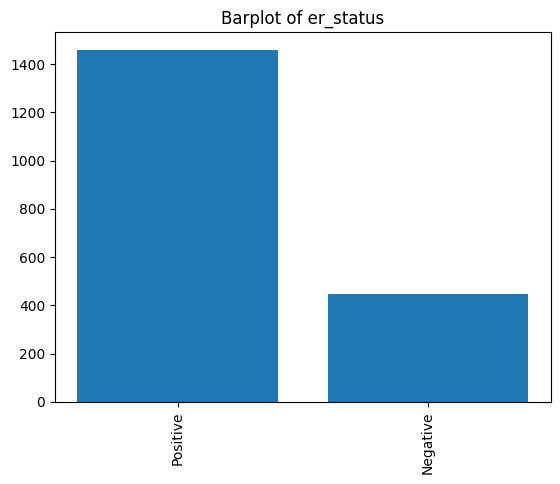

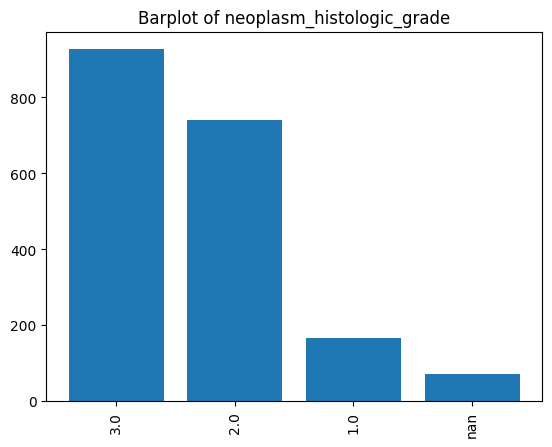

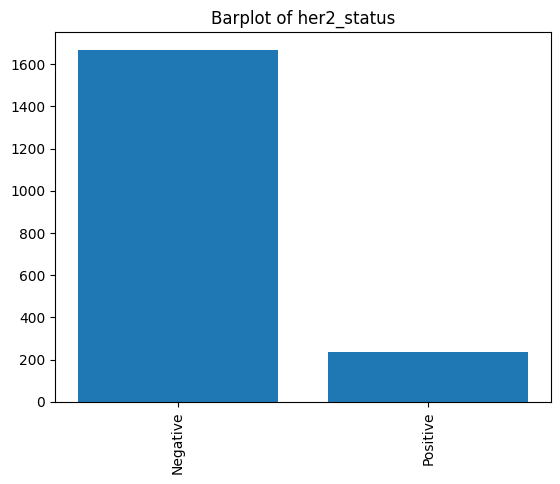

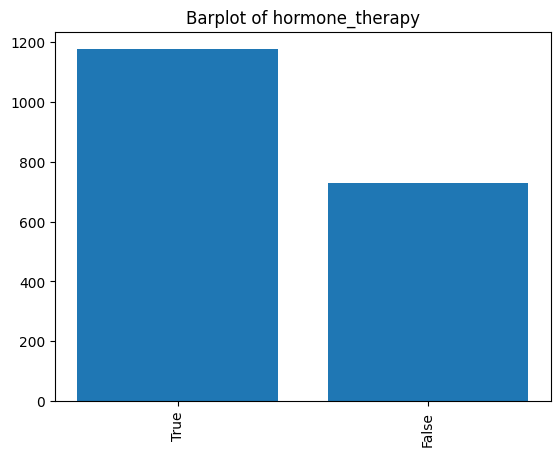

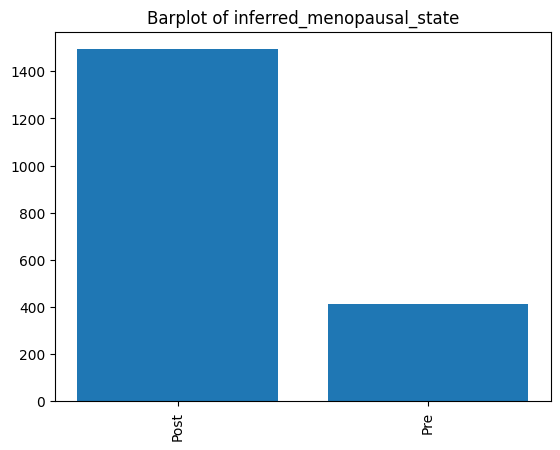

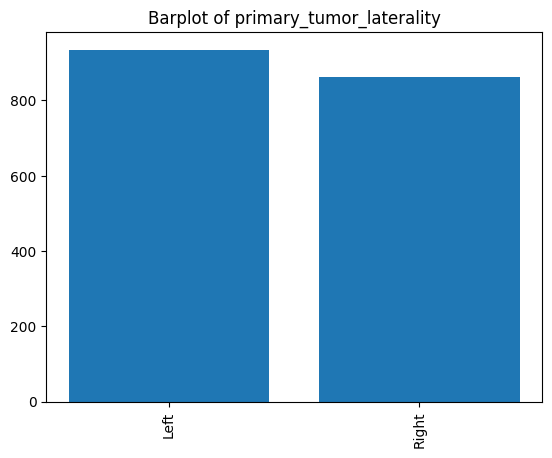

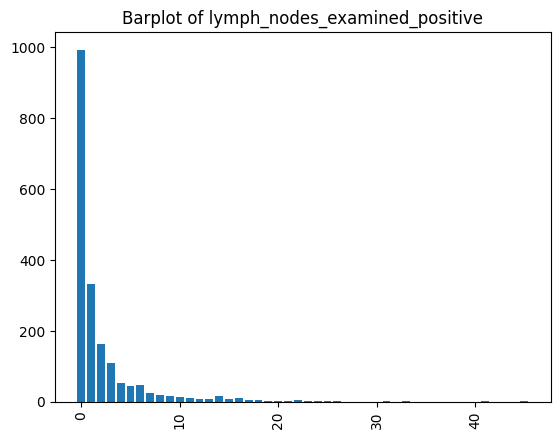

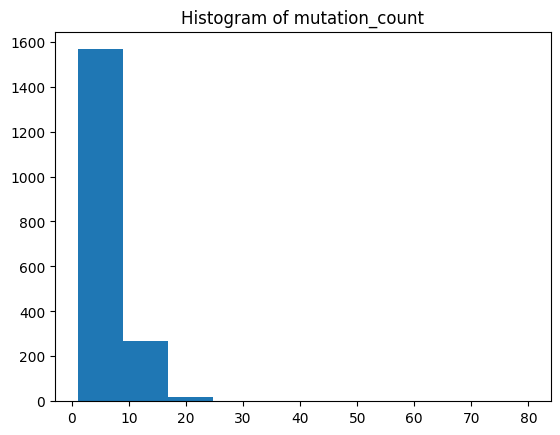

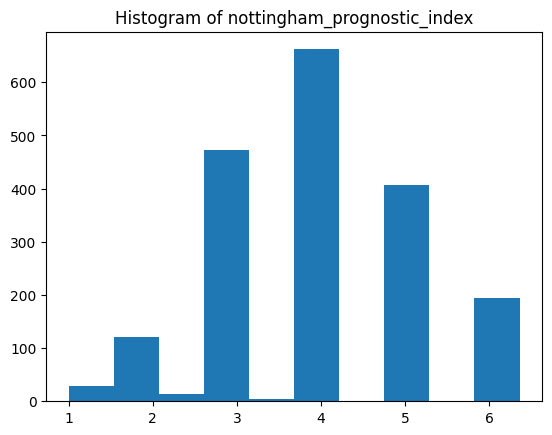

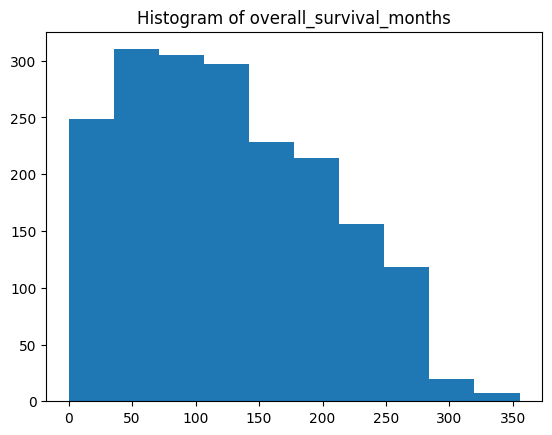

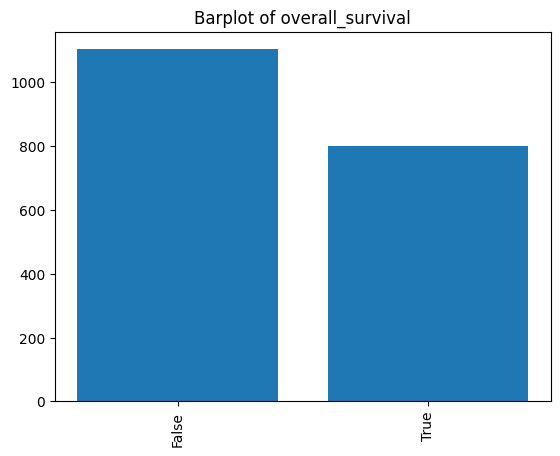

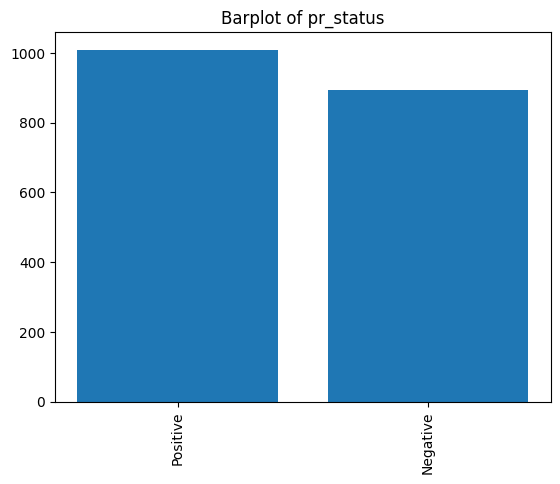

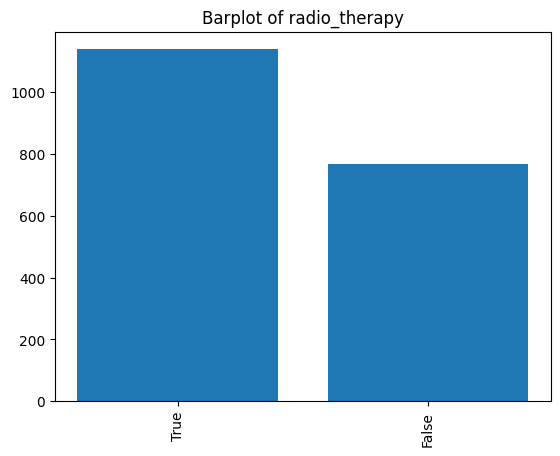

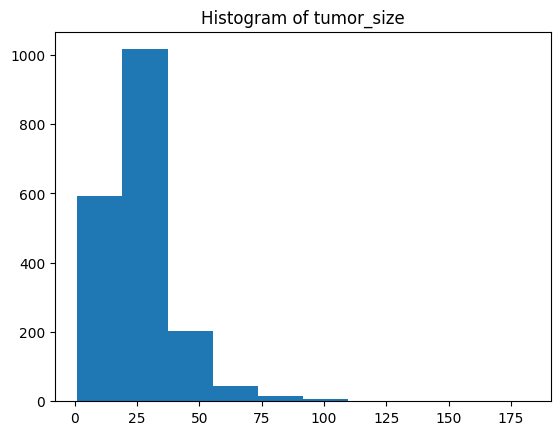

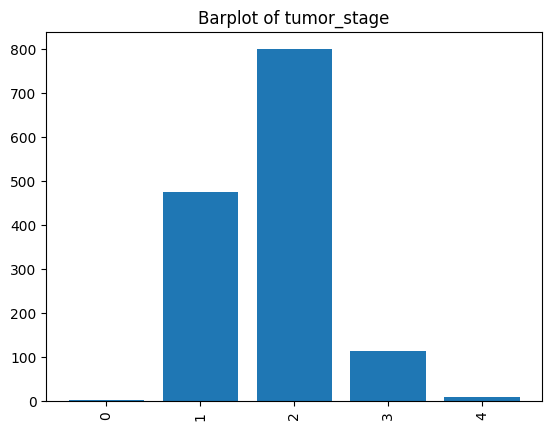

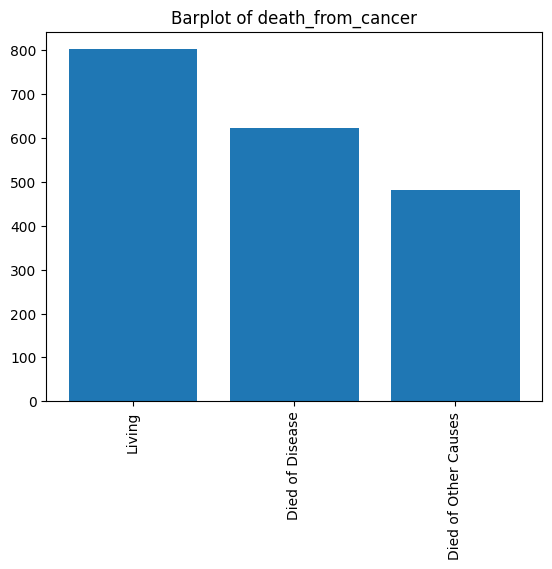

In [59]:
# Visualize the columns
plot_df = df.copy()
plot_df['chemotherapy'] = df['chemotherapy'].astype('bool').astype('str').astype('object')
plot_df['hormone_therapy'] = df['hormone_therapy'].astype('bool').astype('str').astype('object')
plot_df['overall_survival'] = df['overall_survival'].astype('bool').astype('str').astype('object')
plot_df['neoplasm_histologic_grade'] = df['neoplasm_histologic_grade'].astype('object')
plot_df['radio_therapy'] = df['radio_therapy'].astype('bool').astype('str').astype('object')
plot_df['tumor_stage'] = df['tumor_stage'].astype('object')
plot_df['neoplasm_histologic_grade'] = df['neoplasm_histologic_grade'].astype('str').astype('object')

# Draw plots for every column except patient_id
for column in plot_df.columns[1:]:
    if pd.api.types.is_float_dtype(plot_df[column]):
        plt.hist(plot_df[column].dropna())
        plt.title(f'Histogram of {column}')
    elif pd.api.types.is_integer_dtype(plot_df[column]) or pd.api.types.is_object_dtype(plot_df[column]):
        counts = plot_df[column].value_counts()
        plt.bar(counts.index, counts)
        plt.title(f'Barplot of {column}')
        plt.xticks(rotation=90)
    plt.savefig(f'plots/{column}.png')
    plt.show()

# Change all categorical values to dtype category
#columns_to_convert = df.select_dtypes(include=['object']).columns
#df[columns_to_convert] = df[columns_to_convert].astype('category')

In [60]:
# Check how often each pation is in the data
value_counts = df['patient_id'].value_counts().sort_values(ascending=False)
value_counts

patient_id
0       1
48      1
6       1
8       1
10      1
       ..
7296    1
7297    1
7298    1
7285    1
7299    1
Name: count, Length: 1904, dtype: int64

In [61]:
# As all patient only exist once in the df drop patient id
df = df.drop(['patient_id'], axis=1)

In [62]:
#for column in df.columns:
#    if df[column].dtype == 'object' or df[column].dtype == 'int64':
#        non_na_values = df[column].dropna()
#        if not non_na_values.empty:
#            df[column] = df[column].apply(
#                lambda x: np.random.choice(non_na_values) if pd.isna(x) else x
#            )
#    elif df[column].dtype == 'float64':
#        min_val = df[column].min()
#        max_val = df[column].max()
#        df[column] = df[column].apply(
#            lambda x: np.random.uniform(min_val, max_val) if pd.isna(x) else x
#        )
#        
# recheck if there are any empty values
#rows_with_nulls = df[df.isnull().any(axis=1)]
#rows_with_nulls

In [63]:
#rows_with_nulls = df[df.isnull().any(axis=1)]
#rows_with_nulls

## Survival analysis

In [195]:
# Change all categorical values to dtype category
columns_to_convert = plot_df.select_dtypes(include=['object']).columns
plot_df[columns_to_convert] = plot_df[columns_to_convert].astype('category')

# Get a structured array that indicates, wheter the survival time is uncensored (True if the patitiend died from the diseases 
# and the survival months) 
data_y = np.array(
    [(row['death_from_cancer'] == 'Died of Disease', row['overall_survival_months']) for _, row in plot_df.iterrows()],
    dtype=[('Uncensored', bool), ('SurvivalMonths', float)]
)
data_x = plot_df.drop(['death_from_cancer', 'death_from_cancer', 'overall_survival'], axis=1)

In [196]:
data_y["SurvivalMonths"]

array([140.5       ,  84.63333333, 163.7       , ..., 175.9666667 ,
        86.23333333, 201.9       ])

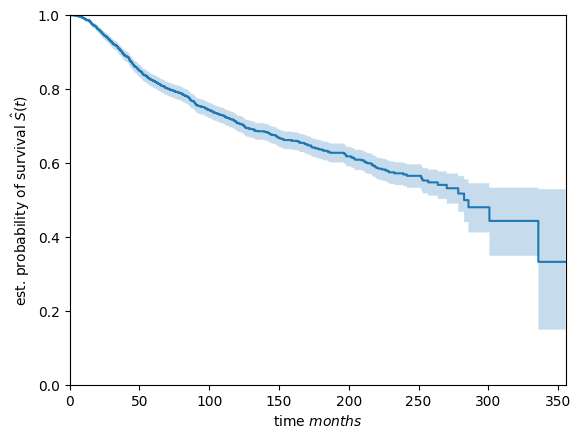

In [203]:
# Plot the Kaplan-Meier-Estimator
time, survival_prob, conf_int = kaplan_meier_estimator(
    data_y["Uncensored"], data_y["SurvivalMonths"], conf_type="log-log"
)
plt.step(time, survival_prob, where="post")
plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")
plt.ylim(0, 1)
plt.xlim(0, np.max(time))
plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $months$")
plt.savefig('plots/kaplan_meier_estimator.png')
plt.show()

In [71]:
survival_prob

array([1.        , 0.99947451, 0.99947451, ..., 0.33243759, 0.33243759,
       0.33243759])

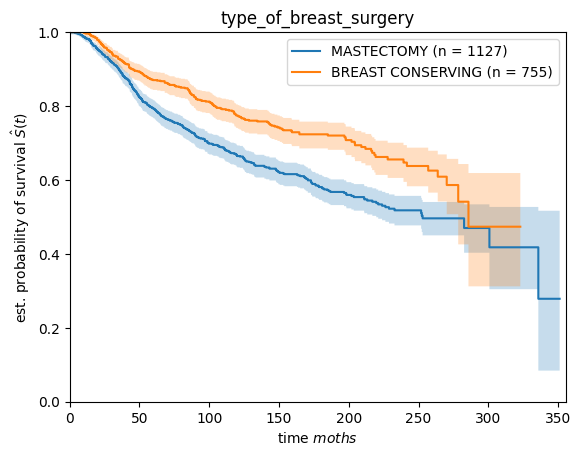

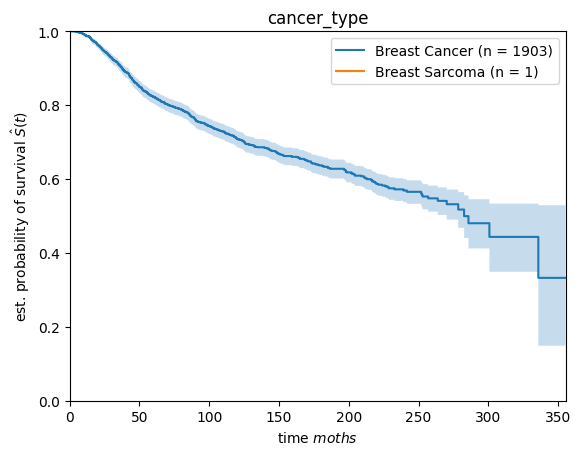

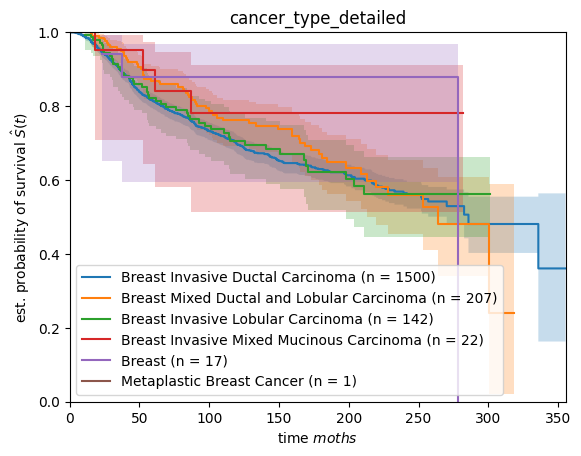

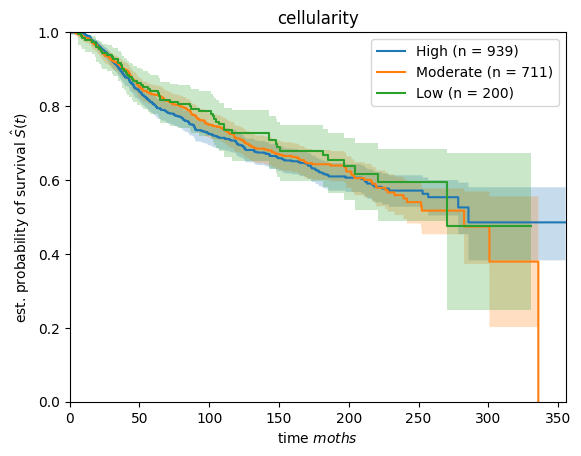

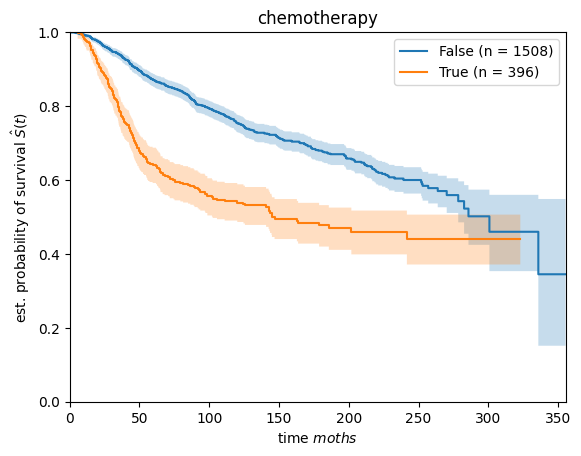

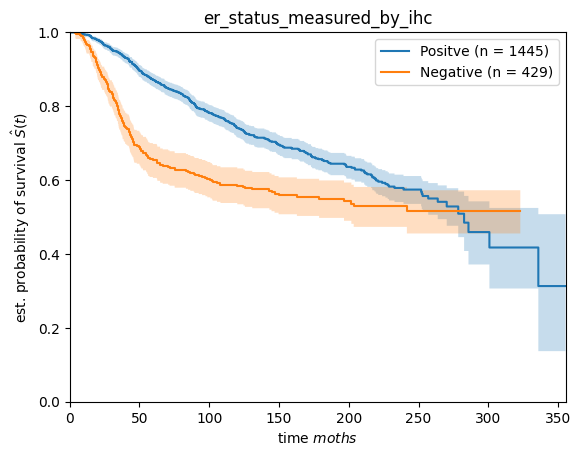

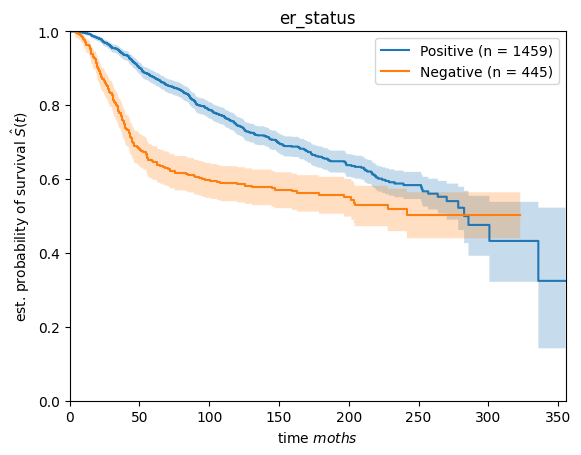

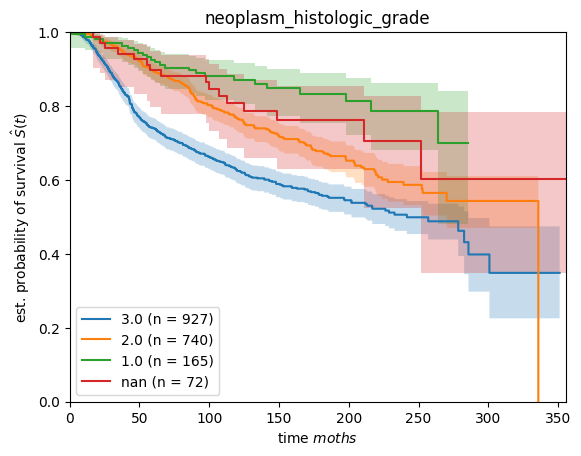

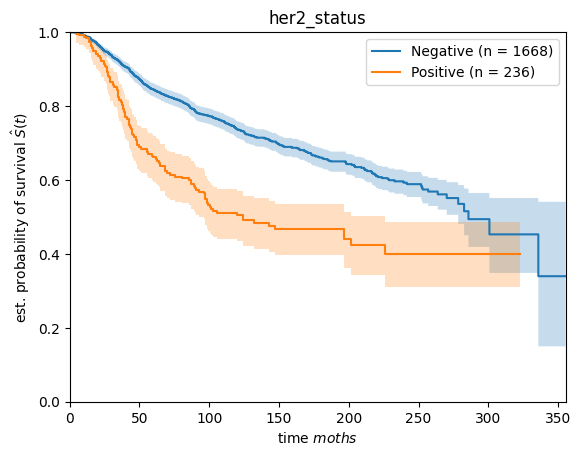

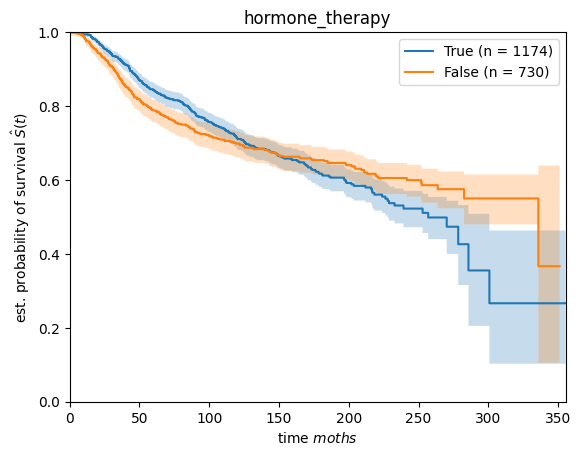

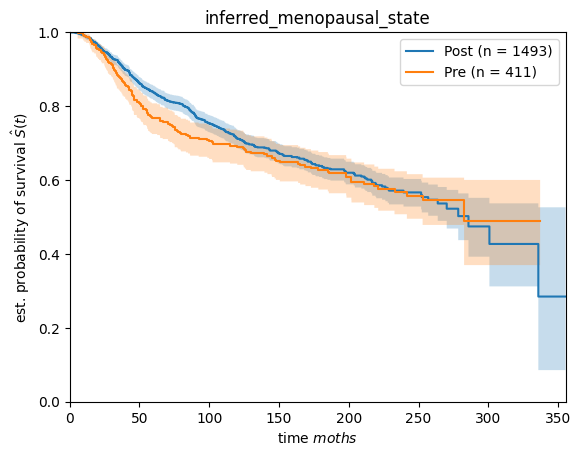

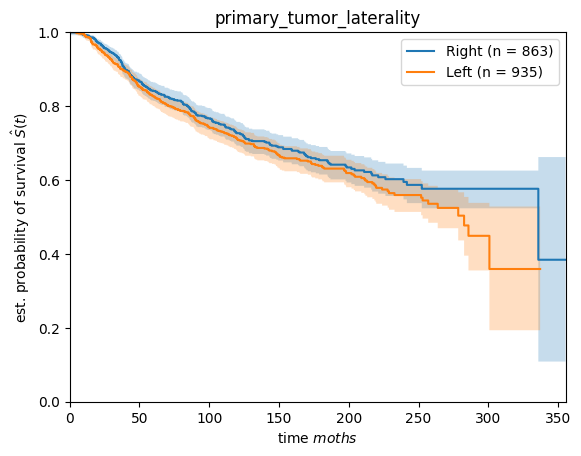

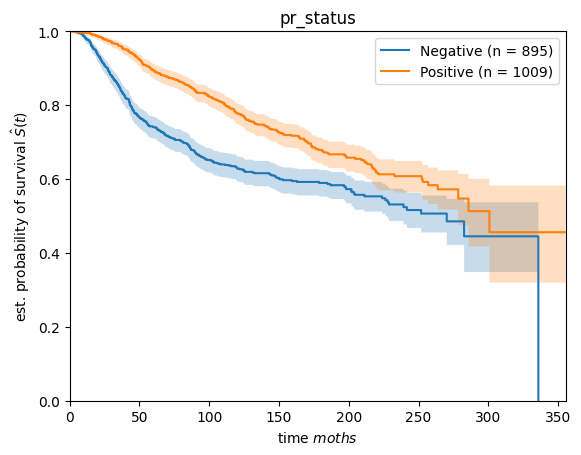

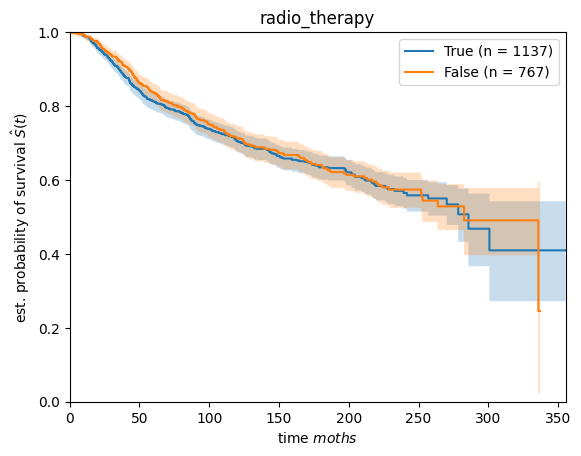

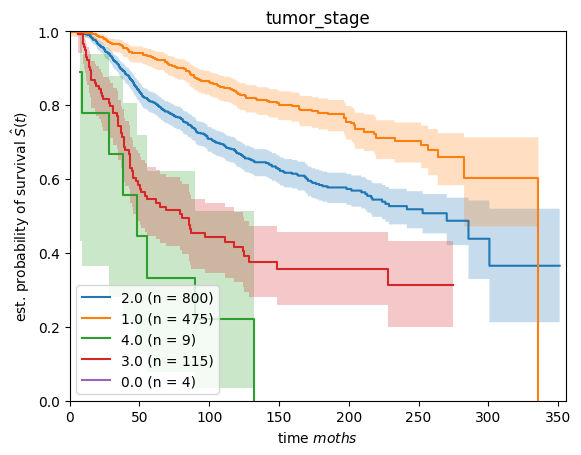

In [75]:
# Analyze by different categories
for column in data_x.columns:
    if column == 'lymph_nodes_examined_positive':
        continue
    if data_x[column].dtype == 'category':
        for value in data_x[column].unique():
            if pd.isna(value):
                continue
            mask = data_x[column] == value
            time, survival_prob, conf_int = kaplan_meier_estimator(
                data_y["Uncensored"][mask], data_y["SurvivalMonths"][mask], conf_type="log-log"
            )
            plt.step(time, survival_prob, where="post", label=f"{value} (n = {mask.sum()})")
            plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")
        
        plt.ylim(0, 1)
        plt.xlim(0, np.max(data_y["SurvivalMonths"]))
        plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
        plt.xlabel("time $moths$")
        plt.legend(loc="best")
        plt.title(column)
        plt.savefig(f'plots/kaplan_meier_estimator_{column}.png')
        plt.show()

In [98]:
# Replace nan in categorical values with a string 'nan'
#categorical_columns = data_x.select_dtypes(include=['category']).columns
#data_x[categorical_columns] = data_x[categorical_columns].astype('object')
#data_x[categorical_columns] = data_x[categorical_columns].fillna('nan')
#data_x[categorical_columns] = data_x[categorical_columns].astype('category')

# One-hot-encode
data_x_numeric = data_x # OneHotEncoder().fit_transform(data_x)
data_x_numeric = data_x_numeric.select_dtypes(include=[np.number])

# Drop non-numeric columns
data_x_numeric = data_x_numeric[numeric_columns.columns]
# Remove all nan categories
# columns_to_remove = [col for col in data_x_numeric.columns if "=nan" in col]
# data_x_numeric = data_x_numeric.drop(columns=columns_to_remove)

# Show data
data_x_numeric.head()

,patient_id,age_at_diagnosis,cohort,lymph_nodes_examined_positive,mutation_count,nottingham_prognostic_index,overall_survival_months,tumor_size
0,0,75.65,1,10,NaN,6.044,140.500000,22.0
1,2,43.19,1,0,2.0,4.020,84.633333,10.0
2,5,48.87,1,1,2.0,4.030,163.700000,15.0
3,6,47.68,1,3,1.0,4.050,164.933333,25.0
4,8,76.97,1,8,2.0,6.080,41.366667,40.0


In [99]:
import numpy as np
from sklearn.impute import KNNImputer
nan = np.nan
# X = [[1, 2, nan], [3, 4, 3], [nan, 6, 5], [8, 8, 7]]
imputer = KNNImputer(n_neighbors=2, weights="uniform")
data_x_numeric2 = imputer.fit_transform(data_x_numeric)
data_x_numeric = pd.DataFrame(data_x_numeric2, columns=data_x_numeric.columns)

In [151]:
data_x_numeric = data_x_numeric.drop(['patient_id','cohort'], axis=1)

In [157]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_x_scaled = scaler.fit_transform(data_x_numeric)

In [159]:
data_x_scaled

array([[ 1.12235889e+00,  1.96078771e+00, -6.59128572e-01,
         1.75755736e+00,  2.01518153e-01, -2.81727567e-01],
       [-1.37931684e+00, -4.90840738e-01, -9.07295628e-01,
        -1.13780438e-02, -5.30544031e-01, -1.07603928e+00],
       [-9.41562119e-01, -2.45677893e-01, -9.07295628e-01,
        -2.63824433e-03,  5.05524883e-01, -7.45076064e-01],
       ...,
       [ 1.39722861e-01,  1.05414873e+01, -4.10961516e-01,
         1.76280124e+00,  6.66264075e-01, -8.31496399e-02],
       [ 5.62194424e-03,  2.45111340e+00,  2.31887610e+00,
         8.88821299e-01, -5.09578050e-01, -8.31496399e-02],
       [-8.22372773e-02, -2.45677893e-01, -6.59128572e-01,
         8.80081499e-01,  1.00608769e+00, -4.14112852e-01]])

In [185]:
# Fit the Cox’s proportional hazard’s model, 

from sksurv.linear_model import CoxnetSurvivalAnalysis
set_config(display="text")  # displays text representation of estimators
alphas = np.logspace(-4, 2, 200)
estimator = CoxnetSurvivalAnalysis(max_iter=1000000, alphas=alphas, fit_baseline_model=True)
estimator.fit(data_x_scaled, data_y)

CoxnetSurvivalAnalysis(alphas=array([1.00000000e-04, 1.07189132e-04, 1.14895100e-04, 1.23155060e-04,
       1.32008840e-04, 1.41499130e-04, 1.51671689e-04, 1.62575567e-04,
       1.74263339e-04, 1.86791360e-04, 2.00220037e-04, 2.14614120e-04,
       2.30043012e-04, 2.46581108e-04, 2.64308149e-04, 2.83309610e-04,
       3.03677112e-04, 3.25508860e-04, 3.48910121e-04, 3.73993730e-04,
       4.00880633e-0...
       2.02550194e+01, 2.17111795e+01, 2.32720248e+01, 2.49450814e+01,
       2.67384162e+01, 2.86606762e+01, 3.07211300e+01, 3.29297126e+01,
       3.52970730e+01, 3.78346262e+01, 4.05546074e+01, 4.34701316e+01,
       4.65952567e+01, 4.99450512e+01, 5.35356668e+01, 5.73844165e+01,
       6.15098579e+01, 6.59318827e+01, 7.06718127e+01, 7.57525026e+01,
       8.11984499e+01, 8.70359136e+01, 9.32930403e+01, 1.00000000e+02]),
                       fit_baseline_model=True, max_iter=1000000)

In [179]:
from sksurv.metrics import concordance_index_censored

# Assuming X_test and y_test are your test data
ci = concordance_index_censored(data_y['Uncensored'], data_y['SurvivalMonths'], estimator.predict(data_x_numeric))
print(f"Concordance Index: {ci[0]:.3f}")

Concordance Index: 1.000


/Users/ddehncke/.pyenv/versions/3.9.7/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but CoxnetSurvivalAnalysis was fitted without feature names
  warnings.warn(


In [201]:
# Example: Select the coefficients corresponding to the first alpha value (this is arbitrary)
# If you want a different alpha, you can select accordingly.
selected_alpha_index = 3  # Choose an index from 0 to len(estimator.alphas_) - 1

# Extract coefficients for the chosen alpha
selected_coefficients = estimator.coef_[:, selected_alpha_index]

# Convert the coefficients to a Pandas Series for easy inspection
coefficients = pd.Series(selected_coefficients, index=data_x_numeric.columns)

# Sort the coefficients by magnitude (absolute value) to see the most influential features
coefficients_sorted = coefficients.sort_values(ascending=False)

# Display the top coefficients
print("Top coefficients:")
print(coefficients_sorted.head(20))

Top coefficients:
nottingham_prognostic_index       0.163693
tumor_size                        0.045279
lymph_nodes_examined_positive     0.022669
mutation_count                    0.016591
age_at_diagnosis                 -0.084976
overall_survival_months         -71.046147
dtype: float64


In [186]:
predicted_survival = estimator.predict_survival_function(data_x_scaled)

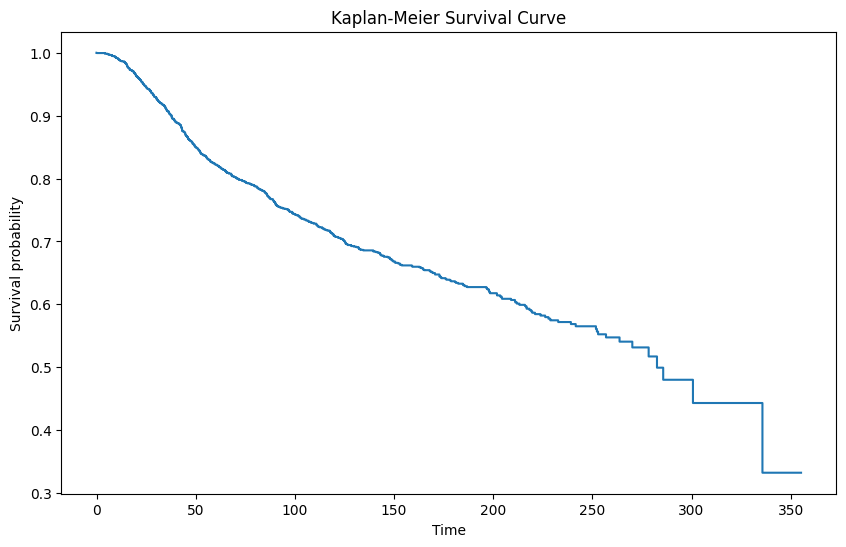

In [193]:
from sksurv.nonparametric import kaplan_meier_estimator
import matplotlib.pyplot as plt

# Example: Plotting survival curves for a specific variable
time, survival_prob = kaplan_meier_estimator(data_y['Uncensored'], data_y['SurvivalMonths'])

plt.figure(figsize=(10, 6))
plt.step(time, survival_prob, where="post")
plt.xlabel('Time')
plt.ylabel('Survival probability')
plt.title('Kaplan-Meier Survival Curve')
plt.show()



In [192]:
## Stop here!

array([(False, 140.5       ), (False,  84.63333333),
       ( True, 163.7       ), ..., ( True, 175.9666667 ),
       (False,  86.23333333), (False, 201.9       )],
      dtype=[('Uncensored', '?'), ('SurvivalMonths', '<f8')])

In [109]:
cleaned = data_x_numeric.copy()
for column in cleaned.columns:
    if cleaned[column].dtype == 'object' or cleaned[column].dtype == 'int64':
        non_na_values = cleaned[column].dropna()
        if not non_na_values.empty:
            cleaned[column] = cleaned[column].apply(
                lambda x: np.random.choice(non_na_values) if pd.isna(x) else x
            )
    elif cleaned[column].dtype == 'float64':
        min_val = cleaned[column].min()
        max_val = cleaned[column].max()
        cleaned[column] = cleaned[column].apply(
            lambda x: np.random.uniform(min_val, max_val) if pd.isna(x) else x
        )

data_y_cleaned = data_y[cleaned.index]

In [110]:
# Fit the Cox’s proportional hazard’s model, 

set_config(display="text")  # displays text representation of estimators
estimator = CoxPHSurvivalAnalysis()
estimator.fit(cleaned, data_y_cleaned)

/Users/ddehncke/.pyenv/versions/3.9.7/lib/python3.9/site-packages/sksurv/linear_model/coxph.py:179: RuntimeWarning: divide by zero encountered in log
  loss -= (numerator - n_events * np.log(risk_set)) / n_samples
/Users/ddehncke/.pyenv/versions/3.9.7/lib/python3.9/site-packages/sksurv/linear_model/coxph.py:238: RuntimeWarning: invalid value encountered in divide
  z = risk_set_x / risk_set
/Users/ddehncke/.pyenv/versions/3.9.7/lib/python3.9/site-packages/sksurv/linear_model/coxph.py:241: RuntimeWarning: invalid value encountered in divide
  a = risk_set_xx / risk_set


ValueError: LAPACK reported an illegal value in 5-th argument.

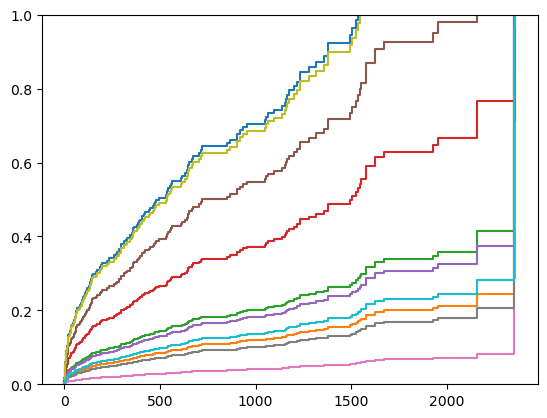

,afb,age,av3,bmi,chf,cvd,diasbp,gender,hr,los,miord,mitype,sho,sysbp
0,1.0,83.0,0.0,25.54051,0.0,1.0,78.0,0.0,89.0,5.0,1.0,0.0,0.0,152.0
1,0.0,49.0,0.0,24.02398,0.0,1.0,60.0,0.0,84.0,5.0,0.0,1.0,0.0,120.0
2,0.0,70.0,0.0,22.14290,0.0,0.0,88.0,1.0,83.0,5.0,0.0,1.0,0.0,147.0
3,0.0,70.0,0.0,26.63187,1.0,1.0,76.0,0.0,65.0,10.0,0.0,1.0,0.0,123.0
4,0.0,70.0,0.0,24.41255,0.0,1.0,85.0,0.0,63.0,6.0,0.0,1.0,0.0,135.0


In [17]:

from sksurv.datasets import load_whas500
X, y = load_whas500()
X = X.astype(float)
estimator = CoxPHSurvivalAnalysis().fit(X, y)
chf_funcs = estimator.predict_cumulative_hazard_function(X.iloc[:10])
for fn in chf_funcs:

    plt.step(fn.x, fn(fn.x), where="post")


plt.ylim(0, 1)

plt.show()

X.head()

In [ ]:
def calculate_vif(X):
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif
        

out = calculate_vif(cleaned)
out.sort_values("VIF", ascending=False)

,Variable,VIF
21,nottingham_prognostic_index,54.937991
0,age_at_diagnosis,38.231628
14,neoplasm_histologic_grade,36.087078
3,cancer_type_detailed=Breast Invasive Ductal Ca...,35.711486
12,er_status_measured_by_ihc=Positve,14.936936
13,er_status=Positive,14.628281
26,tumor_stage,7.303872
11,cohort,6.204150
6,cancer_type_detailed=Breast Mixed Ductal and L...,5.659882
4,cancer_type_detailed=Breast Invasive Lobular C...,4.129904


In [ ]:
cleaned_x = cleaned.copy()
for x in range(len(cleaned_x.columns)):
    vif = calculate_vif(cleaned_x)
    sorted_vif = vif.sort_values("VIF", ascending=False)
    cleaned_x = cleaned_x[sorted_vif[1:]["Variable"]]
    set_config(display="text")  # displays text representation of estimators
    estimator = CoxPHSurvivalAnalysis()
    try:
        estimator.fit(cleaned_x, data_y_cleaned)
    except Exception as e:
        print(e, len(cleaned_x.columns))


    

Matrix is singular. 26
Matrix is singular. 25
Matrix is singular. 24
Matrix is singular. 23
Matrix is singular. 22
Matrix is singular. 21
Matrix is singular. 20
Matrix is singular. 19
Matrix is singular. 18
Matrix is singular. 17
Matrix is singular. 16
Matrix is singular. 15
Matrix is singular. 14
Matrix is singular. 13
Matrix is singular. 12
Matrix is singular. 11
Matrix is singular. 10
Matrix is singular. 9
Matrix is singular. 8
Matrix is singular. 7
Matrix is singular. 6
Matrix is singular. 5
Matrix is singular. 4
Matrix is singular. 3
Matrix is singular. 2
Matrix is singular. 1


ValueError: zero-size array to reduction operation maximum which has no identity